<a href="https://colab.research.google.com/github/jarvez31/Object_representation_model/blob/main/Obj_graph_mlp_catasforge_local2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

### Install the extra modules

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
# tf.compat.v1.disable_eager_execution()
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [2]:
###############------------------- LOAD MODULES ---------------------#############

from tensorflow.keras.models import model_from_yaml, model_from_json
from tensorflow import keras
from functions import *
import pickle, shapely
import numpy as np
import math as mt
import tempfile
import tensorflow as tf
import pickle
from scipy import misc
import glob, csv
from tensorflow.keras import layers
from shapely.geometry import box, Polygon, Point, LinearRing
#from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Reshape, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D, concatenate, Concatenate
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K 
from keras.regularizers import Regularizer 
# from keras_gcn import GraphConv
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
from sklearn import preprocessing
from numpy import linalg as LA
import pandas as pd
from tensorflow.keras.utils import plot_model
from numpy import matlib
from progressbar import ProgressBar
import tensorflow_model_optimization as tfmot
from matplotlib import cm
main = " "

In [3]:
#@title Setup Parameters
fol1 = "test_wale_2" #@param {type:"string"}
traj1 = "traj_obj(sh1)_20k.pk1" #@param {type:"string"}
imgs = "frames_traj(col_obj)(sh1)_bw_20k.pk1" #@param {type:"string"}
old_model_n = "train_1" #@param {type:"string"}
# fisher_n = "frames_traj(wo)_bw_20k.pk1" #@param {type:"string"}
new_model_n = "train_2" #@param {type:"string"}
epochs = 1 #@param {type:"number"}
lam = 20 #@param {type:"number"}
# test_p =  7#@param {type:"number"}
# img_fol = "traj_four_objs_diffW" #@param {type:"string"}

#@markdown ### Standard deviation for population code for x,y
std_dev =  0.1 #@param {type:"slider", min:0, max:1, step:0.1}

#@markdown ### Model Params
Retrain = True #@param {type:"boolean"}
Train = False #@param {type:"boolean"}
Retrain_nocat = False #@param {type:"boolean"}
# Analysis = False #@param {type:"boolean"}
pre_conv = True #@param {type:"boolean"}
obj_pres = True #@param {type:"boolean"}
pi_use = "no_osc" #@param ["osc", "no_osc"]
act_func = "relu" #@param {type:"string"}
learn_rate = 0.001 #@param {type:"number"}
random_state = 42 #@param {type:"number"}

# DATA

### Trajectory

[(0.25, 0.25, 0.55, 0.55)]
359.98288887198055
20000
20000


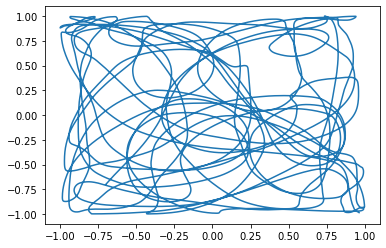

In [4]:
###--------------------- LOAD TRAJECTORY --------------------###

fol = main + fol1 + "/"
traj = traj1
with open(traj, "rb") as f:
    d = pickle.load(f)
    f.close()
locals().update(d)

x = np.asarray(x)
y = np.asarray(y)
pos = np.column_stack((x,y))
# x = x[:-1]
# y = y[:-1]
# theta = theta[:-1]
env = [(1.0, -1.0), (1.0, 1.0), (-1.0, 1.0), (-1.0, -1.0), (1.0, -1.0)]
# obj_c = [(0.4, 0.4)]#, (0.4, 0.4)]
# obj_c_plot = [(-0.4, -0.4), (0.4, 0.4)]#, (-0.4, 0.4)]#, (-0.4, 0.4)]#, (0.4, -0.4), (0.0, 0.0)]
obj_c, obj_c_plot = obj_cent(traj1)

hf_sz = 0.15
out_bound = 0.25
obj_ver = [(c[0]-hf_sz, c[1]-hf_sz, c[0]+hf_sz, c[1]+hf_sz) for c in obj_c]
print(obj_ver)
obj_ver_outer = [(c[0]-hf_sz-out_bound, c[1]-hf_sz-out_bound, c[0]+hf_sz+out_bound, c[1]+hf_sz+out_bound) for c in obj_c]

sq1_env = box(-1.0, -1.0, 1.0, 1.0)
sq1 = box(-0.8, -0.8, 0.8, 0.8)
sq2 = [box(obj_ver[j][0], obj_ver[j][1], obj_ver[j][2], obj_ver[j][3]) for j in range(len(obj_ver))]
sq3 = [box(obj_ver_outer[k][0], obj_ver_outer[k][1], obj_ver_outer[k][2], obj_ver_outer[k][3]) for k in range(len(obj_ver_outer))]
k1_env = list(sq1_env.exterior.coords)
k1 = list(sq1.exterior.coords)
k2 = [list(l.exterior.coords) for l in sq2]
k3 = [list(ll.exterior.coords) for ll in sq3]

env = [[m[0] for m in k1_env ], [m[1] for m in k1_env ]]
obj = [[[m[0] for m in obji ], [m[1] for m in obji ]] for obji in k2]
obj_boun = [[[m[0] for m in objbi ], [m[1] for m in objbi ]] for objbi in k3]
# env = np.asarray(env)
# obj = np.asarray(obj)

theta = np.asarray(theta)
theta_rad = np.radians(theta)
print(max(theta))
print(len(theta))

## objects to do plotting that show shifting
obj_ver_plot = [(c[0]-hf_sz, c[1]-hf_sz, c[0]+hf_sz, c[1]+hf_sz) for c in obj_c_plot]
sq2_plot = [box(obj_ver_plot[j][0], obj_ver_plot[j][1], obj_ver_plot[j][2], obj_ver_plot[j][3]) for j in range(len(obj_ver_plot))]
k2_plot = [list(l.exterior.coords) for l in sq2_plot]
obj_plot = [[[m[0] for m in obji ], [m[1] for m in obji ]] for obji in k2_plot]

# reward around the object
reward = rew_new(x, y, obj_ver_outer, present = obj_pres)
print(len(reward))
plt.plot(x,y)

### Reward

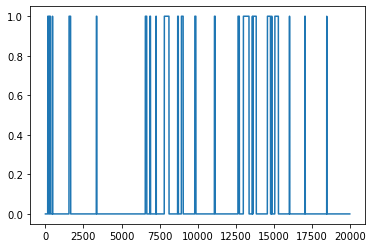

2205


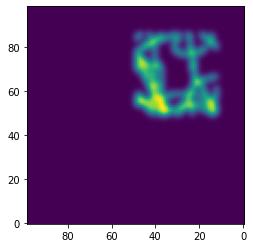

------------------------Load Images-----------------------------
(20000, 32, 32, 3)
------------------Calculate PI------------------------
no_osc
------using PI WITHOUT oscillators-----
20000
----------------Split data in test and train----------------
(19999, 1, 32, 32, 3)
(16000, 100) (4000, 100)
(16000, 32, 32, 3) (4000, 32, 32, 3)
(16000,) (4000,)


In [5]:
###------- Plot reward-------######
plt.plot(reward)
plt.show()
from scipy.ndimage import gaussian_filter
import scipy
from scipy import signal, ndimage
ot = reward
print(np.sum(reward))
thresh = np.min(ot)*0
firr = np.nonzero(ot!=thresh)
firposgrid = pos[firr[0], :]
title = "pred reward without object"
firing_map = firing_rate_map(firposgrid, ot, firr, title)
plt.imshow(firing_map, origin= 'upper')
ax=plt.gca()                            # get the axis
ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
ax.set_xlim(ax.get_xlim()[::-1])
plt.show()


###------- Load Images -------######
print("------------------------Load Images-----------------------------")
with open(imgs, "rb") as f:
    train_imgs = pickle.load(f)
    f.close()

print(train_imgs.shape)


#### --------- Path Integration  --------####
print("------------------Calculate PI------------------------")
beta = [3*np.pi]
pi_lay = PI(x, y, theta_rad, beta, pi_use)


### ---------  Split the data  -------####
print("----------------Split data in test and train----------------")
from sklearn.model_selection import train_test_split
seq_len = 1

pi_seq = seq_data(pi_lay, seq_len)
train_imgs_seq = seq_data(train_imgs, seq_len)
r_seq = seq_data(reward, seq_len)
print(train_imgs_seq.shape)

sub_imgs = train_test_split(train_imgs, test_size=0.2, random_state=random_state)
sub_pi = train_test_split(pi_lay, test_size=0.2, random_state=random_state)
sub_r = train_test_split(reward, test_size=0.2, random_state=random_state)


sub_pi_t = sub_pi
sub_imgs_t = sub_imgs
sub_r_t = sub_r
comp_data = [train_imgs, pi_lay]

print(sub_pi_t[0].shape, sub_pi_t[1].shape)
print(sub_imgs_t[0].shape, sub_imgs_t[1].shape)
print(sub_r_t[0].shape, sub_r_t[1].shape)

# MODEL

### Setup Architecture

In [8]:
from keras.layers import Dropout, GlobalAveragePooling2D
from keras.regularizers import l2
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.constraints import max_norm

def custom_lr_loss(y_true, y_pred):
  mse = tf.keras.losses.MeanSquaredError()
  t_loss = mse(y_true, y_pred)
  global model
  model.optimizer.lr.assign(0.0)
  if y_true == 1:
    model.optimizer.lr.assign(0.0001)
  return t_loss

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learn_rate,
    decay_steps=10000,
    decay_rate=0.98,
    staircase=True)

# Train the model 
if Train:
  tf.keras.backend.clear_session()
  model = model_arch(comp_data, nodes = 100, activ = 'sigmoid', lr = lr_schedule)
  model.summary()

if Retrain:
  opt = tf.keras.optimizers.Adam(learning_rate = learn_rate)

  with open(fol+"mod_dict_" + old_model_n + ".pk1", "rb") as f:
      old_mod_dict = pickle.load(f)
      f.close()

  model = model_arch_catas(comp_data, old_mod_dict, nodes=100, lam=lam, activ = 'sigmoid', lr = lr_schedule)
  if Retrain_nocat:
    keras.backend.clear_session()
    model = model_arch(comp_data, nodes = 100, activ = 'sigmoid', lr = lr_schedule)
    model.compile(optimizer=opt, loss = custom_lr_loss, )
  else:
    model.compile(optimizer=opt, loss = custom_lr_loss, )
  print("Loading weights from previous model")

  model.load_weights(fol + old_model_n +".h5")
  model.loss
  model.summary() 

#########-----------------RETRAINING MODEL---------------#########
(None, 2, 100)
Loading weights from previous model
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 IMAGE (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 CONV_1 (Conv2D)                (None, 32, 32, 8)    608         ['IMAGE[0][0]']                  
                                                                                                  
 MAXPOOL_1 (MaxPooling2D)       (None, 16, 16, 8)    0           ['CONV_1[0][0]']                 
                                                                                                  
 CONV_2 (Conv2D)                (None, 16, 16, 4)    804         ['MAXPOOL_

### Train the model

In [9]:
for ii in range(epochs):
    num_images = pos[0]-1
    loss = []
    val_loss = []
    history = model.fit(
              [sub_imgs_t[0], sub_pi_t[0]],
              sub_r_t[0],
              epochs = 1,
              batch_size = 1 ,
              validation_data = ([sub_imgs_t[1], sub_pi_t[1]], sub_r_t[1]),
              shuffle = True)
    
    predicted_r = model.predict(comp_data)

    print(ii)  
    ot = predicted_r
    thresh = np.min(ot)*0
    firr = np.nonzero(ot!=thresh)
    firposgrid = pos[firr[0], :]
    firing_map = firing_rate_map(firposgrid, ot, firr, title)
    plt.imshow(firing_map, origin= 'upper')
    firing_map = firing_rate_map(firposgrid, ot, firr, title)
    plt.imshow(firing_map, origin= 'upper')
    plt.colorbar()
    ax=plt.gca()                            # get the axis
    ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
    ax.set_xlim(ax.get_xlim()[::-1])
    plt.show()

model.save(fol+ new_model_n +".h5")
wts = model.weights
print(wts[-1])

 1291/16000 [=>............................] - ETA: 34s - loss: 20.4062

KeyboardInterrupt: ignored

### Fisher Compute

In [ ]:
img_ind = np.where(sub_r_t[0] == 1)

print('Processing Fisher Information...')
I_new = computer_fisher(model, [sub_imgs_t[0], sub_pi_t[0]], img_ind[0])
print('Processing Finish!')
hist_ = history.history

# I_new = New_I.copy()
New_I = I_new.copy()
for j in range(len(New_I)):
  if np.amax(New_I[j]) == 0:
    New_I[j] = New_I[j]/(np.amax(New_I[j]) + 0.00001)
  else:
    New_I[j] = New_I[j]/np.amax(New_I[j])

if Train:
  I_tot = I_new
else:
  I_tot = I + I_new

model_dict = {"weights": wts, "fisher": I_tot, "history": hist_} 
with open(fol+"mod_dict_" + namm + ".pk1", 'wb') as ff:
    pickle.dump(model_dict, ff)
    ff.close()

kk = str(len(pos))
plt.plot(hist_["loss"], "-r", label = "loss")
plt.plot(hist_["val_loss"], "--b", label = "val_loss")
plt.legend()
plt.title("training 1 without objects "+kk)
plt.show()

In [ ]:
# if Retrain:
for i in range(len(I_new)):
  # print(np.amax(New_I[i]))
  # print(np.amax(I_new[i]))
  # print(np.amax(I_new[i]))
  print(I_new[i])
  # print(np.amax(wts[i]))

# LAYERWISE OUTPUT ANALYSIS

#### Save & load layerwise output

In [ ]:
tf.keras.backend.clear_session()
autoencoder_model = model_arch(comp_data, nodes = 100, activ = 'sigmoid', lr = lr_schedule)
autoencoder_model.load_weights(fol+ new_model_n +".h5")
outputs  = [layer.output for layer in autoencoder_model.layers]
encoded = {}

In [ ]:
# GET OUTPUT FOR THE REQUIRED LAYERS
if pre_conv:
  import keras_bert
  inp = autoencoder_model.input
  layers = ['MEC', 'LEC', 'D1', 'D2', 'D3', 'graph_conv']
  lim = [0.8, 0.8, 0.9, 0.9, 0.9, 0.8, 0.8]
  lay_nam = layers

  encoded_pre = {}

  for i in range(len(layers)):
    layer_output = autoencoder_model.get_layer(layers[i]).output
    functor = K.function(inp, layer_output)
    temp1 = functor(comp_data)
    if layers[i] == 'graph_conv':
      encoded_pre['graph_LEC'] = temp1[:,0,:]
      encoded_pre['graph_MEC'] = temp1[:,1,:]
    else:
      encoded_pre[lay_nam[i]] = temp1



  from matplotlib.pyplot import close
  outs = lay_nam[:-1] + ['graph_LEC', 'graph_MEC']
  outs_n = lay_nam[:-1] + ["gr_LEC", "gr_MEC"]#, 'CA1']#, "CA1", "CA3"]
  pos_out = pos

  for k in range(len(outs)):
    if outs[k] == 'rnn_1' or 'rnn_2':
      resp_neurons = np.transpose(np.squeeze((encoded_pre[outs[k]])))
    else:
      resp_neurons = np.squeeze(np.transpose(encoded_pre[outs[k]]))
    avg = np.mean(abs(resp_neurons))
    std_dev = np.std(resp_neurons)
    m = np.amax(resp_neurons)
    num = 0
    for j in range(int(np.divide(len(resp_neurons),50))):
        onm = outs_n[k]
        for i in range(50):
            plt.subplot(7,8,i+1)
            thresh = np.amax(resp_neurons[i+num]) * lim[k]
            firr = np.nonzero(resp_neurons[i+num]>thresh)
            firposgrid = pos_out[firr[0], :]
            plt.scatter(firposgrid[:,0], firposgrid[:,1], s = 3, color = 'red', marker='o', zorder = 5)
            if obj_pres:
              for tt in range(len(obj_plot)):
                if tt == len(obj_plot)-1:
                  plt.plot(obj_plot[tt][0], obj_plot[tt][1], 'b')
                else:
                  plt.plot(obj_plot[tt][0], obj_plot[tt][1],'--', 'b')
            else:
              for tt in range(len(obj_plot)):
                plt.plot(obj_plot[tt][0], obj_plot[tt][1],'--', 'b')

            plt.plot(env[0], env[1])
            plt.suptitle('output mesh with obj '+str(num)+ ' to '+str(num+50)+' neurons from '+ onm +' layer, threshold=' +str(lim[k])+" act_func=" + "relu", fontsize = 20, va = 'bottom', ha = 'center')

        num = num + 50
        figure = plt.gcf() # get current figure
        figure.set_size_inches(14, 10)
        plt.savefig(fol + onm + "_" + new_model_n + "_" + str(num), bbox_inches='tight')
        plt.show()
        close()


In [ ]:
plt.rcParams['figure.figsize'] = [30,5]
predicted_r = autoencoder_model.predict(comp_data)
plt.plot(predicted_r, label = 'predicted_r')
plt.plot(reward, label = 'actual_r')
plt.legend()
plt.show()

In [ ]:
plt.plot(reward)
plt.show()
from scipy.ndimage import gaussian_filter
import scipy
from scipy import signal, ndimage
#ot = predicted_output[1][:,-1,:]
#ot = gt
# ot = np.ndarray.flatten(encoded['val'])
ot = predicted_r
print(np.sum(reward))
print(ot.shape)
thresh = np.min(ot)*0
# print(thresh)
firr = np.nonzero(ot!=thresh)
# print(firr[0])
#firr = np.nonzero(abs(resp_neurons[i+num])>thresh)
firposgrid = pos[firr[0], :]
# print(firposgrid)
title = "pred reward without object"
firing_map = firing_rate_map(firposgrid, ot, firr, title)
plt.imshow(firing_map, origin= 'upper')
plt.colorbar()
ax=plt.gca()                            # get the axis
ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
ax.set_xlim(ax.get_xlim()[::-1])

#### Plotting layer wise output

------------------------------


------------------------------


------------------------------

In [ ]:
from pylab import *
layer_weight = autoencoder_model.get_layer("graph_conv").get_weights()
A = layer_weight[0]
figure(1)
imshow(A)
colorbar()
grid(True)
print(np.count_nonzero(A == 0))

In [ ]:
# plt.rcParams['figure.figsize'] = [30,5]
# plt.rcParams['font.size'] = 20
# plt.plot(encoded["MEC"][:,17])
# plt.plot(reward)
# plt.show()
# close()

In [ ]:
A.reshape(1,2500)
plt.hist(A)
plt.show()